# Loading data, importing packages

In [277]:
import sklearn
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [278]:
# Import the data
tree = pd.read_csv('tree.csv')
tree['t'] = tree['t'].replace(to_replace=0, value=0.0001)

vert_genes = pd.read_csv('vert_genes.csv')

In [279]:
# Creating the graph

def create_graph(tree, alpha, beta, sigma_sq):
    G = nx.DiGraph()
    for _, row in tree.iterrows():
        if not pd.isna(row['Parent']):
            G.add_edge(int(row["Parent"]), int(row["Child"]), time = row["t"], a = alpha*row["t"], b = beta, variance = sigma_sq*row["t"])
            
    return G

G = create_graph(tree, alpha = 0, beta = 1, sigma_sq = 2500)

## Visualizing the graph

In [280]:
def visualize_tree(G, level = False):
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    if level:
        nodes = list(G.nodes)
        leaves = [node for node in nodes if G.out_degree(node) == 0]
        min_depth = min(pos[node][1] for node in pos)  # Highest Y value
        for leaf in leaves:
            pos[leaf] = (pos[leaf][0], min_depth)

    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, font_size = 7, node_color = "Skyblue", node_size = 100)
    plt.show()

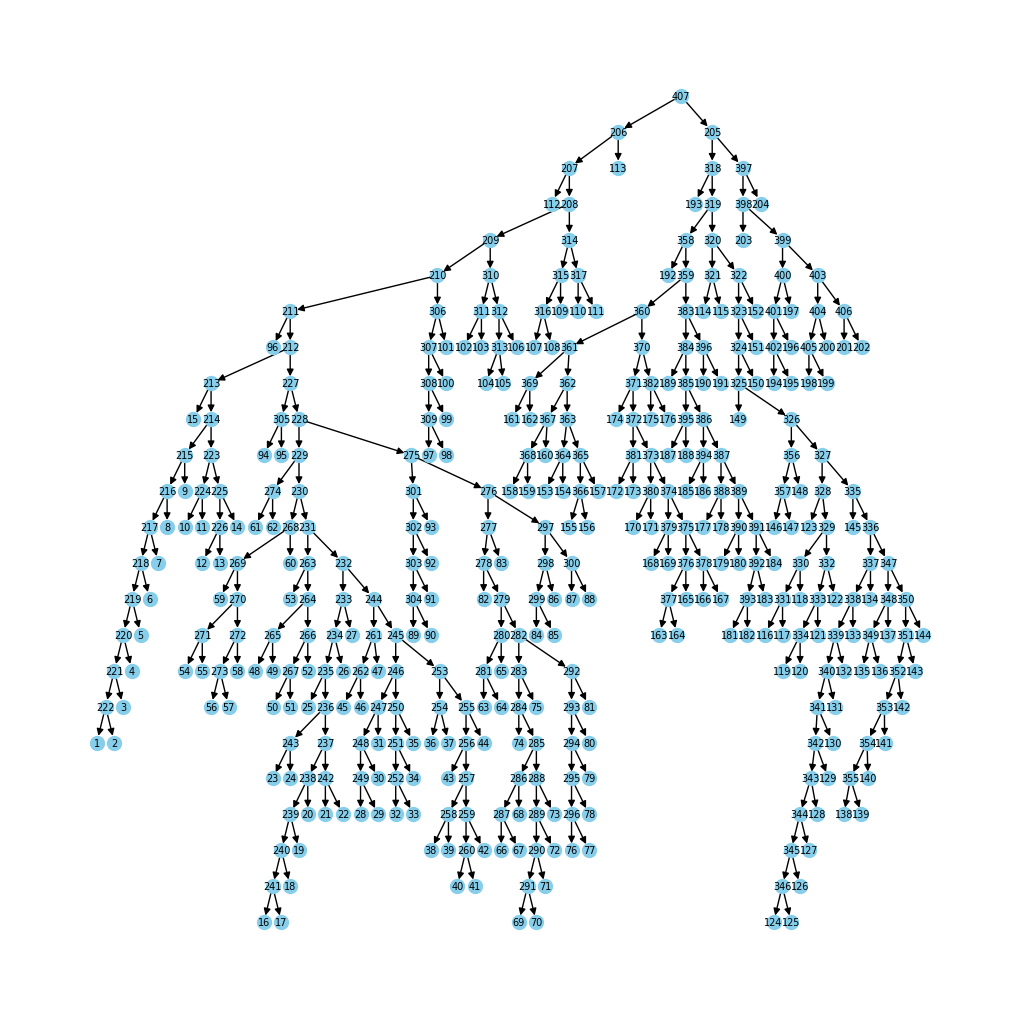

In [281]:
visualize_tree(G)

# Part 1: simulating data

In [282]:
def simulate_node_length_with_parameters(G, parent, simulated_lengths, alpha, beta, sigma_sq):
    for child in G.successors(parent):
        t = G[parent][child]['time']
        mean = alpha * t + beta * simulated_lengths[parent]
        std = np.sqrt(sigma_sq * t)
        simulated_lengths[child] = np.random.normal(mean, std)
        simulate_node_length_with_parameters(G, child, simulated_lengths, alpha, beta, sigma_sq)
    
    return simulated_lengths

def simulate_data_for_learning(G, n, alpha, beta, sigma_sq, alpha_0, sigma_0_sq, root, learn_params = True, only_X = True):
    X_values = []
    Y_values = []
    
    all_nodes = list(G.nodes)  # Get all nodes in the graph

    for _ in range(n):
        simulated_lengths = {}
        
        # Simulate root node first
        simulated_lengths[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        
        # Simulate all other nodes recursively
        simulated_lengths = simulate_node_length_with_parameters(G, root, simulated_lengths, alpha, beta, sigma_sq)
        if only_X:
            leaf_nodes = [node for node in all_nodes if G.out_degree(node) == 0]
            simulated_x = [simulated_lengths[node] for node in leaf_nodes]
            
            X_values.append(simulated_x)
        else:
            X_values.append([simulated_lengths[node] for node in all_nodes])
            
        if learn_params:
            Y_values.append([alpha,beta,sigma_sq])
        else:
            Y_values.append(simulated_lengths[root])

    return np.array(X_values), np.array(Y_values)

learn_parameters = False

X, y = simulate_data_for_learning(G, 1000, alpha = 0.5, beta = 1, sigma_sq = 2500, alpha_0 = 50000, sigma_0_sq = 5000, root = 407, learn_params=learn_parameters)

print(X.shape)
print(y.shape)

print(y[10])

(1000, 204)
(1000,)
49879.43564721093


## Linear regression fit to simulated data

In [283]:
def linearregression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)


    return mse, mae, rmse, r2, y_test, y_pred

mse, mae, rmse, r2, y_test, y_pred = linearregression(X,y)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("R2 Score: ", r2)

Mean Squared Error:  4405.257353864297
Mean Absolute Error:  55.062942243333744
Root Mean Squared Error:  66.3721127723406
R2 Score:  0.17539306076053252


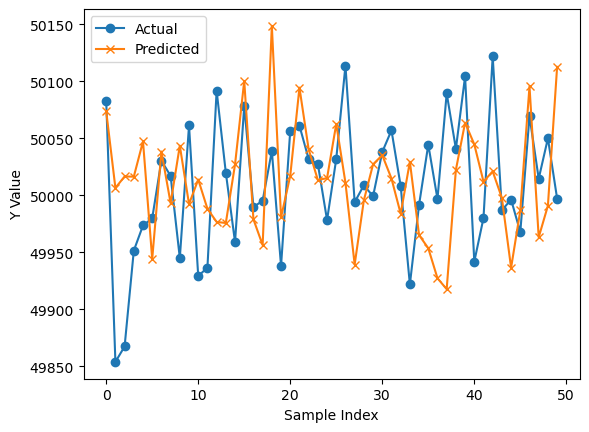

In [284]:
def plot_linreg(n, points):

    X,y = simulate_data_for_learning(G, n, alpha = 0.5, beta = 1, sigma_sq = 2500, alpha_0 = 50000, sigma_0_sq = 5000, root = 407, learn_params=False)
    mse, mae, rmse, r2, Y_test, Y_pred = linearregression(X,y)
    plt.plot(Y_test[:points], label="Actual", marker='o')  # First points values
    plt.plot(Y_pred[:points], label="Predicted", marker='x')
    plt.xlabel("Sample Index")
    plt.ylabel("Y Value")
    plt.legend()
    plt.show()

plot_linreg(1000, 50)

# Part II: inference

In [285]:
def compute_gamma(G):
    gamma = np.eye(len(G.nodes)) # Initialize gamma as an identity matrix

    # Iterate through the nodes in the graph
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            print(f"Node {node} is the root node.")
            continue
        else:
            gamma[parent-1, node -1] = -G[parent][node]['b'] # Determine the dependency between parent and child nodes with -b
    return gamma

def compute_beta(G):
    beta = np.zeros((len(G.nodes), 1))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            continue
        a = G[parent][node]['a'] # The constant term in the mean of the CPD
        beta[node-1] = a
        
    return beta

def compute_sigma(G, sigma_0_sq = 5000):
    sigma = np.zeros((len(G.nodes)))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            # Assign the default value for the root node
            sigma[node - 1] = sigma_0_sq
        else:
            # Access the edge attribute 'variance' only if parent exists
            variance = G[parent][node]['variance']
            sigma[node - 1] = variance
    return sigma

def compute_J_and_h(alpha, beta, sigma_sq, sigma_0_sq = 5000):
    
    G = create_graph(tree, alpha, beta, sigma_sq)

    beta = compute_beta(G)
    sigma = compute_sigma(G, sigma_0_sq)
    gamma = compute_gamma(G)


    J = np.zeros_like(gamma)
    
    # Iterate over each row in gamma
    for i in range(len(gamma)):
        # Get the i-th row (gamma_i) and the corresponding sigma_i
        gamma_i = gamma[i, :]
        sigma_i = sigma[i]
        
        # Compute the outer product of gamma_i with itself, scaled by 1/sigma_i^2 
        outer_product = np.outer(gamma_i, gamma_i) / (sigma_i) 
        
        # Add the outer product to the sum matrix
        J += outer_product
    h = np.sum([(beta[i] / sigma[i]) * gamma[i] for i in range(len(G))], axis=0)
    return J, h

J, h = compute_J_and_h(alpha = 0.5, beta = 1, sigma_sq = 2500)

Node 407 is the root node.


## Checking that J is reasonable

In [286]:
def check_J(J):
    negative_indices = np.where(J < 0)
    negative_values = J[negative_indices]

    print(f"Number of negative values in J: {negative_values.size}")

    if negative_values.size > 0:
        print("Negative values in J:")
        for index, value in zip(zip(*negative_indices), negative_values):
            print(f"Index: {index}, Value: {value}")
    else:
        print("All values in J are non-negative.")

    symmetric = np.allclose(J, J.T, atol=1e-8)
    print("Is J symmetric?", symmetric)

    eigenvalues = np.linalg.eigvalsh(J)
    positive_semi_definite = np.all(eigenvalues >= 1e-8)
    print("Is J positive semi-definite?", positive_semi_definite)

    print("Smallest eigenvalue:", np.min(eigenvalues))

check_J(J)

Number of negative values in J: 812
Negative values in J:
Index: (0, 221), Value: -0.00012608526799548551
Index: (1, 221), Value: -0.00012608526799548551
Index: (2, 220), Value: -0.00015926338274126575
Index: (3, 219), Value: -0.00016816528296733865
Index: (4, 218), Value: -0.00017905798486704885
Index: (5, 217), Value: -0.00018952612809550938
Index: (6, 216), Value: -0.00020186279565266943
Index: (7, 215), Value: -0.00017493652446087593
Index: (8, 214), Value: -0.00017910753431676934
Index: (9, 223), Value: -0.00012307692307692307
Index: (10, 223), Value: -0.00012307692307692307
Index: (11, 225), Value: -0.0005333333333333334
Index: (12, 225), Value: -0.0005333333333333334
Index: (13, 224), Value: -0.0002
Index: (14, 212), Value: -0.00017324442667204974
Index: (15, 240), Value: -0.0008
Index: (16, 240), Value: -0.0008
Index: (17, 239), Value: -0.0004
Index: (18, 238), Value: -7.804878048780487e-05
Index: (19, 237), Value: -0.001163619438262711
Index: (20, 241), Value: -6.7015650667517

In [287]:
def get_sub_matrices(scope, X_values, J, h):
    X_indices = np.isin(scope, X_values)
    Z_indices = ~X_indices

    J_ZZ = J[Z_indices, :][:, Z_indices]
    J_ZX = J[Z_indices, :][:, X_indices]
    J_XZ = J_ZX.T
    J_XX = J[X_indices, :][:, X_indices]
    J_ZZ_inv = np.linalg.inv(J_ZZ)

    h_X = h[X_indices]
    h_Z = h[Z_indices]

    # print("J_ZZ size:", J_ZZ.shape)
    # print("J_ZX size:", J_ZX.shape)
    # print("J_XZ size:", J_XZ.shape)
    # print("J_XX size:", J_XX.shape)
    # print("J_ZZ_inv size:", J_ZZ_inv.shape)
    # print("h_X size:", h_X.shape)
    # print("h_Z size:", h_Z.shape)

    return J_ZZ, J_ZX, J_XZ, J_XX, J_ZZ_inv, h_X, h_Z

def get_conditional_distribution(J, h, X_values, X_indices):
    scope = [i for i in range(1, len(J) + 1)]
    J_ZZ, J_ZX, J_XZ, J_XX, J_ZZ_inv, h_X, h_Z = get_sub_matrices(scope, X_indices, J, h)

    J_reduced = J_ZZ
    h_reduced = h_Z- J_ZX @ X_values

    return J_reduced, h_reduced


def test_conditional_distribution():
    J, h = compute_J_and_h(alpha = 0.5, beta = 1, sigma_sq = 2500)
    X, y = simulate_data_for_learning(G, 1, alpha = 0.5, beta = 1, sigma_sq = 2500, alpha_0 = 50000, sigma_0_sq = 5000, root = 407, learn_params=False)

    X_values = X[0]
    leaf_nodes = [n for n in G.nodes if G.out_degree(n) == 0]
    X_obs_indices = leaf_nodes
    X_obs_values = np.array([X_values[n - 1] for n in X_obs_indices])  # adjust for 1-based scope
    J_reduced, h_reduced = get_conditional_distribution(J, h, X_obs_values, X_obs_indices)
    print("J_reduced:", J_reduced)
    print("h_reduced:", h_reduced)

    return J_reduced, h_reduced


J_reduced, h_reduced = test_conditional_distribution()

J_reduced

Node 407 is the root node.
J_reduced: [[ 0.00047522  0.0002      0.         ...  0.          0.
  -0.0002    ]
 [ 0.0002      0.00030287 -0.00010287 ...  0.          0.
  -0.0002    ]
 [ 0.         -0.00010287  0.00028556 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.00178928  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.00038355
   0.        ]
 [-0.0002     -0.0002      0.         ...  0.          0.
   0.0002    ]]
h_reduced: [ 2.00000000e-04  5.09784995e+00  4.14303425e+00 -9.24068420e+00
  0.00000000e+00 -2.71050543e-20  6.05667870e+00 -6.05667870e+00
  8.71665371e+00 -8.71665371e+00  8.95631749e+00 -1.39579030e-01
  1.35354973e+00 -6.49470205e-01 -5.10306300e-01 -6.20987554e-01
 -3.08073624e-01  4.60994351e+00 -2.71050543e-20  1.22674155e+01
  9.93296312e+00  4.31204499e+01  2.71050543e-20  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.97271252e+00  1.29112744e+00 -2.15866369

array([[ 0.00047522,  0.0002    ,  0.        , ...,  0.        ,
         0.        , -0.0002    ],
       [ 0.0002    ,  0.00030287, -0.00010287, ...,  0.        ,
         0.        , -0.0002    ],
       [ 0.        , -0.00010287,  0.00028556, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.00178928,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00038355,  0.        ],
       [-0.0002    , -0.0002    ,  0.        , ...,  0.        ,
         0.        ,  0.0002    ]])

## Computing a clique tree

In [288]:
def compute_clique_tree(G):
    C = nx.Graph()

    G_working = G.copy()
    leaves = [node for node in G_working.nodes if G_working.out_degree(node) == 0]
    G_working.remove_nodes_from(leaves)

    index = min(G_working.nodes) -1 if all(isinstance(n, int) for n in G_working.nodes) else 0

    for node in G_working.nodes:
        parent = node
        children = list(G_working.neighbors(parent))
        C.add_node(parent, variables=[parent])
        for child in children:
            pair_clique = index
            C.add_node(pair_clique, variables=[parent, child])
            C.add_edge(parent, pair_clique)
            C.add_edge(pair_clique, child)
            index = index - 1

    return C


C = compute_clique_tree(G)

## Message passing

In [289]:
NoV = len([node for node in C.nodes if len(C.nodes[node]['variables']) == 1]) -1
maxIndex = max([node for node in C.nodes])
away_from_zero = maxIndex - NoV
minIndex = min([node for node in C.nodes if len(C.nodes[node]['variables']) == 1])

print("Away from zero: ", away_from_zero)
print("Max index: ", maxIndex)
print("Min index: ", minIndex)
print("Number of variables in the graph: ", NoV)

def mapping_GTM(index_in_graph):
    return index_in_graph - away_from_zero 

def mapping_MTG(index_in_matrix):
    return index_in_matrix + away_from_zero

Away from zero:  205
Max index:  407
Min index:  205
Number of variables in the graph:  202


## Peters method - recursive calls (do we compute messages double?)

In [290]:
def single_clique(G):
    leaves = [node for node in G.nodes if G.out_degree(node) == 0]
    H = G.copy()
    H.remove_nodes_from(leaves)
    H = H.to_undirected()
    return H


def compute_J_i_arrow_j(clique_tree, i, j, J, h, J_messages, h_messages):
    
    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)

    i_idx = mapping_GTM(i)
    j_idx = mapping_GTM(j)

    if not neighbors:
        J_messages[i_idx][j_idx] = -J[i_idx, j_idx] * J[j_idx, i_idx] / J[i_idx, i_idx]
    else:
        J_sum = np.sum(compute_J_i_arrow_j(clique_tree, k, i, J, h, J_messages, h_messages) for k in neighbors)
        J_messages[i_idx][j_idx] = -J[i_idx, j_idx] * J[j_idx, i_idx] / (J[i_idx, i_idx] + J_sum)

    return J_messages[i_idx][j_idx]


def compute_h_i_arrow_j(clique_tree, i, j, J, h, J_messages, h_messages):

    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)

    i_idx = mapping_GTM(i)
    j_idx = mapping_GTM(j)

    if not neighbors:
        h_messages[i_idx][j_idx] = -J[i_idx, j_idx] * h[i_idx] / J[i_idx, i_idx]
    else:
        J_sum = np.sum(compute_J_i_arrow_j(clique_tree, k, i, J, h, J_messages, h_messages) for k in neighbors)
        h_sum = np.sum(compute_h_i_arrow_j(clique_tree, k, i, J, h, J_messages, h_messages) for k in neighbors)
        Ji_backslash_j = J[i_idx, i_idx] + J_sum
        hi_backslash_j = h[i_idx] + h_sum
        h_messages[i_idx][j_idx] = (-J[i_idx, j_idx] * hi_backslash_j) / (Ji_backslash_j)

    return h_messages[i_idx][j_idx]


def inference_algorithm(full_tree, J, h, observed_X, Z):
    clique_tree = single_clique(full_tree)

    print("Number of nodes in clique tree:", len(clique_tree.nodes))
    J_messages = np.full(J.shape, np.nan)
    h_messages = np.full(J.shape, np.nan)

    n_observed = len(observed_X)
    J_reduced, h_reduced = get_conditional_distribution(J, h, observed_X, list(range(1, n_observed + 1)))

    Z_neighbors = list(clique_tree.neighbors(Z))
    Z_idx = mapping_GTM(Z)

    J_zz = J_reduced[Z_idx, Z_idx]

    print("Z neighbors:", Z_neighbors)
    print("Z index:", Z_idx)
    sum_J = np.sum([compute_J_i_arrow_j(clique_tree, k, Z, J_reduced, h_reduced, J_messages, h_messages) for k in Z_neighbors])
    sum_h = np.sum([compute_h_i_arrow_j(clique_tree, k, Z, J_reduced, h_reduced, J_messages, h_messages) for k in Z_neighbors])

    J_hat_Z = J_zz + sum_J
    h_hat_Z = h_reduced[Z_idx] + sum_h

    print(f"J_zz for node {Z}:", J_zz)
    print("Incoming J messages:")
    for k in Z_neighbors:
        val = compute_J_i_arrow_j(clique_tree, k, Z, J_reduced, h_reduced, J_messages, h_messages)
        h_val = compute_h_i_arrow_j(clique_tree, k, Z, J_reduced, h_reduced, J_messages, h_messages)
        print(f"  {k} → {Z}: {val} ({h_val})")

    print("→ Sum of messages:", sum_J)

    return J_hat_Z, h_hat_Z

def information_to_standard(J_hat_Z, h_hat_Z, Z):

    print("J_hat_Z:", J_hat_Z)
    print("h_hat_Z:", h_hat_Z)
    mu = h_hat_Z / J_hat_Z
    sigma = np.sqrt(1 / J_hat_Z)
    return mu, sigma


n = 10
random_index = np.random.choice(range(n))
Z = 407  # root node

X_values, _ = simulate_data_for_learning(G, n, alpha = 0.5, beta = 1, sigma_sq = 2500, alpha_0 = 50000, sigma_0_sq = 5000, root = 407, learn_params=False)

J_hat_Z, h_hat_Z = inference_algorithm(G, J, h, X_values[random_index], Z)
mu, sigma = information_to_standard(J_hat_Z, h_hat_Z, Z)

print("Posterior mean:", mu)
print("Posterior std dev:", sigma)

Number of nodes in clique tree: 203
Z neighbors: [205, 206]
Z index: 202
J_zz for node 407: 0.0002
Incoming J messages:
  205 → 407: -0.0010930446968144924 (-34.690789077097264)
  206 → 407: -0.00017517769654743417 (-1.4234367777901586)
→ Sum of messages: -0.0012682223933619266
J_hat_Z: -0.0010682223933619265
h_hat_Z: -36.11422585488742
Posterior mean: 33807.77830469192
Posterior std dev: nan


C:\Users\Dell\AppData\Local\Temp\ipykernel_8016\173194794.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  J_sum = np.sum(compute_J_i_arrow_j(clique_tree, k, i, J, h, J_messages, h_messages) for k in neighbors)
C:\Users\Dell\AppData\Local\Temp\ipykernel_8016\173194794.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  J_sum = np.sum(compute_J_i_arrow_j(clique_tree, k, i, J, h, J_messages, h_messages) for k in neighbors)
C:\Users\Dell\AppData\Local\Temp\ipykernel_8016\173194794.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_sum = np.sum(compute_h_i_arrow_j(clique_tree, k, i, 

In [291]:
NoV = len([node for node in C.nodes if len(C.nodes[node]['variables']) == 1]) -1
maxIndex = max([node for node in C.nodes])
away_from_zero = maxIndex - NoV
minIndex = min([node for node in C.nodes if len(C.nodes[node]['variables']) == 1])

print("Away from zero: ", away_from_zero)
print("Max index: ", maxIndex)
print("Min index: ", minIndex)
print("Number of variables in the graph: ", NoV)

def mapping_GTM(index_in_graph):
    return index_in_graph - away_from_zero 

def mapping_MTG(index_in_graph):
    return index_in_graph + away_from_zero

def compute_message_PTS(i, j, J, J_messages, h_messages):
    
    i_idx = mapping_GTM(i)
    j_idx = mapping_GTM(j)

    J_ji = J[j_idx][i_idx]
    J_ij = J[i_idx][j_idx]

    prev_J_message = J_messages[i_idx][j_idx]
    prev_h_message = h_messages[i_idx]

    if np.isnan(prev_J_message):
        print("ERROR: No previous message found.")


    J_message = -np.dot(J_ji, J_ij) / prev_J_message
    h_message = -np.dot(J_ji, prev_h_message) / prev_J_message

    J_messages[i_idx][j_idx] = J_message
    h_messages[i_idx] = h_message

def compute_message_STP(i, j, index_j, J, h, clique_tree, J_messages, h_messages):
    
    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)

    j_idx = mapping_GTM(index_j)
    i_idx = mapping_GTM(i)
    
    if neighbors is not None:
        J_sum = np.sum([J_messages[mapping_GTM(k)][i_idx] for k in neighbors])
        h_sum = np.sum([h_messages[mapping_GTM(k)] for k in neighbors])

    J_hat_ij = J[i_idx][i_idx] + J_sum
    h_hat_ij = h[i_idx] + h_sum

    J_messages[i_idx][j_idx] = J_hat_ij
    h_messages[i_idx] = h_hat_ij

def upward_pass(clique_tree, J, h, root):

    flags = np.zeros(root + 1)
    order = nx.dfs_postorder_nodes(clique_tree, source=root)

    # order = list(order)[:10]
    J_messages = np.full(J.shape, np.nan)
    h_messages = np.full(h.shape, np.nan)
    counter = 0
    for n in order:
        neighbors = list(clique_tree.neighbors(n))
        for j in neighbors:
            if flags[j] == 0:
                flags[j] = 1
                variables = clique_tree.nodes[n]['variables']
                if len(variables) == 2:
                    print("Neighbor j before mapping:", j)
                    i = variables[1]
                    j = variables[0]
                    print("Sent message from pair clique", n, "to single clique", j, "at timestep", counter)
                    print("Variables for clique", n, ": ", variables)
                    print("i: ", i, "j: ", j)
                    compute_message_PTS(i, j, J, J_messages, h_messages)
                    counter += 1
                else:
                    neighbor_variables = clique_tree.nodes[j]['variables']
                    index_j = neighbor_variables[0]
                    i = n
                    print("Sent message from single clique", i, "to pair clique", j, "at timestep", counter)
                    print("Variables for clique", n, ": ", variables)
                    print("i: ", i, "j: ", j)
                    compute_message_STP(i, j, index_j, J, h, clique_tree, J_messages, h_messages)
                    counter += 1
            else:
                continue

    return J_messages, h_messages

def downward_pass(clique_tree, J, h, root, J_messages, h_messages):
    
    order = nx.dfs_preorder_nodes(clique_tree, source=root)
    flags = np.zeros(root + 1)

    for n in order:
        neighbors = list(clique_tree.neighbors(n))
        for j in neighbors:
            if flags[j] == 0:
                variables = clique_tree.nodes[n]['variables']
                if len(variables) == 2:
                    
                    i = variables[1]
        
                    j = variables[0]
                    print("Variables for clique", n, ": ", variables)
                    print("i: ", i, "j: ", j)
                    compute_message_PTS(i, j, J, J_messages, h_messages)
                else:
                    neighbor_variables = clique_tree.nodes[j]['variables']
                    index_j = neighbor_variables[0]
                    i = n
                    compute_message_STP(i, j, index_j, J, h, clique_tree, J_messages, h_messages)
                flags[j] = 1
            else:
                continue

    return J_messages, h_messages

def compute_clique_beliefs(clique_tree, J, h, J_messages, h_messages):
    
    clique_j = np.zeros(shape=h.shape)
    clique_h = np.zeros(shape=h.shape)
    
    number_of_variables = len(h)
    for i in range(number_of_variables):
        J_i = J[i][i]
        h_i = h[i]

        graph_i = mapping_MTG(i)

        for neighbor in clique_tree.neighbors(graph_i):
            J_message = J_messages[mapping_GTM(neighbor)][i]
            h_message = h_messages[mapping_GTM(neighbor)]
            J_i += J_message
            h_i += h_message
        
        clique_j[i] = J_i
        clique_h[i] = h_i

    return clique_j, clique_h

def message_passing(J, h, clique_tree, root):
    
    J_messages_up, h_messages_up = upward_pass(clique_tree, J, h, root)
    J_messages_down, h_messages_down = downward_pass(clique_tree, J, h, root, J_messages_up, h_messages_up)
    clique_j, clique_h = compute_clique_beliefs(clique_tree, J, h, J_messages_down, h_messages_down)

    return clique_j, clique_h

root = C.nodes[407]['variables'][0]

J, h = compute_J_and_h(alpha = 0.5, beta = 1, sigma_sq = 2500)
G = create_graph(tree, alpha = 0.5, beta = 1, sigma_sq = 2500)
C = compute_clique_tree(G)
X_values,y_values = simulate_data_for_learning(G, 1, alpha = 0.5, beta = 1, sigma_sq = 2500, alpha_0 = 50000, sigma_0_sq = 5000, root = 407, learn_params=False)

conditional_J, conditional_h = get_conditional_distribution(J, h, X_values[0], list(range(1, len(X_values[0]) + 1)))

clique_j, clique_h = message_passing(conditional_J, conditional_h, C, root=407)

Away from zero:  205
Max index:  407
Min index:  205
Number of variables in the graph:  202
Node 407 is the root node.
Sent message from single clique 321 to pair clique 48 at timestep 0
Variables for clique 321 :  [321]
i:  321 j:  48
Neighbor j before mapping: 320
Sent message from pair clique 48 to single clique 320 at timestep 1
Variables for clique 48 :  [320, 321]
i:  321 j:  320
Neighbor j before mapping: 321
Sent message from pair clique 48 to single clique 320 at timestep 2
Variables for clique 48 :  [320, 321]
i:  321 j:  320
Sent message from single clique 331 to pair clique 151 at timestep 3
Variables for clique 331 :  [331]
i:  331 j:  151
Neighbor j before mapping: 330
Sent message from pair clique 151 to single clique 330 at timestep 4
Variables for clique 151 :  [330, 331]
i:  331 j:  330
Neighbor j before mapping: 331
Sent message from pair clique 151 to single clique 330 at timestep 5
Variables for clique 151 :  [330, 331]
i:  331 j:  330
Sent message from single cliq

In [292]:
root = C.nodes[407]['variables'][0]

J, h = compute_J_and_h(alpha = 0.5, beta = 1, sigma_sq = 2500)
G = create_graph(tree, alpha = 0.5, beta = 1, sigma_sq = 2500)
C = compute_clique_tree(G)
X_values,y_values = simulate_data_for_learning(G, 1, alpha = 0.5, beta = 1, sigma_sq = 2500, alpha_0 = 50000, sigma_0_sq = 5000, root = 407, learn_params=False)

conditional_J, conditional_h = get_conditional_distribution(J, h, X_values[0], list(range(1, len(X_values[0]) + 1)))

clique_j, clique_h = message_passing(conditional_J, conditional_h, C, root=407)

def information_to_standard(J_hat_Z, h_hat_Z):

    print("J_hat_Z:", J_hat_Z)
    print("h_hat_Z:", h_hat_Z)
    mu = h_hat_Z / J_hat_Z
    sigma = np.sqrt(1 / J_hat_Z)
    return mu, sigma

J_hat_Z = clique_j[mapping_GTM(root)]
h_hat_Z = clique_h[mapping_GTM(root)]


mu, sigma = information_to_standard(J_hat_Z, h_hat_Z)

print("Posterior mean:", mu)
print("Posterior std dev:", sigma)

Node 407 is the root node.
Sent message from single clique 321 to pair clique 48 at timestep 0
Variables for clique 321 :  [321]
i:  321 j:  48
Neighbor j before mapping: 320
Sent message from pair clique 48 to single clique 320 at timestep 1
Variables for clique 48 :  [320, 321]
i:  321 j:  320
Neighbor j before mapping: 321
Sent message from pair clique 48 to single clique 320 at timestep 2
Variables for clique 48 :  [320, 321]
i:  321 j:  320
Sent message from single clique 331 to pair clique 151 at timestep 3
Variables for clique 331 :  [331]
i:  331 j:  151
Neighbor j before mapping: 330
Sent message from pair clique 151 to single clique 330 at timestep 4
Variables for clique 151 :  [330, 331]
i:  331 j:  330
Neighbor j before mapping: 331
Sent message from pair clique 151 to single clique 330 at timestep 5
Variables for clique 151 :  [330, 331]
i:  331 j:  330
Sent message from single clique 330 to pair clique 42 at timestep 6
Variables for clique 330 :  [330]
i:  330 j:  42
Neig

# Part III: Learning the parameters

In [293]:
def simulate_full_data(G, n_samples, alpha, beta, sigma_sq, alpha_0, sigma_0_sq):
    rows = []

    for _ in range(n_samples):
        simulated = {}
        simulated[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        simulate_node_length_with_parameters(G, root, simulated, alpha, beta, sigma_sq)

        for parent, child in G.edges:
            t = G[parent][child]['time']
            y = simulated[child]
            z = simulated[parent]
            rows.append({
                'Y': y,
                'Z': z,
                't': t
            })

    return pd.DataFrame(rows)

def estimate_alpha_beta_sigma2(data):
    X = data[['t', 'Z']]
    y = data['Y']

    model = LinearRegression().fit(X, y)
    alpha_hat = model.coef_[0]
    beta_hat = model.coef_[1]

    # Residual variance estimate of σ²
    residuals = y - model.predict(X)
    t_values = data['t']
    sigma_sq_hat = np.mean((residuals ** 2) / t_values)

    return alpha_hat, beta_hat, sigma_sq_hat

root = 407
n = 1000
df = simulate_full_data(G, n, alpha=0.5, beta=1, sigma_sq=2500, alpha_0=50000, sigma_0_sq=5000)
alpha_hat, beta_hat, sigma_sq_hat = estimate_alpha_beta_sigma2(df)

print("Estimated alpha:", alpha_hat)
print("Estimated beta:", beta_hat)
print("Estimated sigma_sq:", sigma_sq_hat)

Estimated alpha: 0.5771125371029485
Estimated beta: 0.9993721528628705
Estimated sigma_sq: 2510.996017413352


## Hard assignment EM algorithm

In [294]:
def hard_assignment_EM(n, init_alpha, init_beta, init_sigma_sq, init_alpha0):
    alpha = init_alpha
    beta = init_beta
    sigma_sq = init_sigma_sq
    alpha0 = init_alpha0

    for _ in range(n):
        X, y = simulate_data_for_learning(G, 1, alpha, beta, sigma_sq, alpha0, sigma_sq, root, learn_params=False)
        alpha_hat, beta_hat, sigma_sq_hat = estimate_alpha_beta_sigma2(pd.DataFrame({'Y': y, 'Z': X[0]}))
        alpha0_hat = inference_algorithm(G, J, h, X[0], root)

        alpha = alpha_hat
        beta = beta_hat
        sigma_sq = sigma_sq_hat
        alpha0 = alpha0_hat

    return alpha, beta, sigma_sq, alpha0

alpha_hat, beta_hat, sigma_sq_hat, alpha0_hat = hard_assignment_EM(10, 0.5, 1, 2500, 50000)

ValueError: All arrays must be of the same length